### Calculo las pendientes de la metalicidad y z_50 para las distintas edades

In [16]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import make_profiles as mprof
import z50

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

for j in range(12):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))
    
    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    Ztot = tmet[amask]/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)
    w0, = np.where(Ztot[limit2]>0)
    
    edad  = age[limit2][w0]
    x_str = xn[limit2][w0]
    y_str = yn[limit2][w0]
    z_str = zn[limit2][w0]
    Z_tot = Ztot[limit2][w0]
    m_str = mstr[limit2][w0]
    
    Rstr = np.sqrt(x_str**2 + y_str**2)
    
  
    nb = 14

    delta = (13.8-0.)/nb
    rango = np.arange(0,13.8,delta)

    age_med       = np.zeros(nb)
    slope_met_tot = np.zeros(nb) #en todos los radios
    slope_met     = np.zeros(nb) #en r50
    slope_z50_tot = np.zeros(nb) #en todos los radios
    slope_z50     = np.zeros(nb) #en r50
    value_met     = np.zeros(nb)
    value_z50     = np.zeros(nb)
    k=0
    h=0.1

    for i in rango:

        agelim, = np.where((edad>i) & (edad<i+delta))

        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        z = z_str[agelim]
        m = m_str[agelim]
        Ztotal = Z_tot[agelim]

        age_med[k] = i+delta/2
    
        nbin = 20
        
        if (len(agelim)<2):
            continue

        med_Zt, Z_t, p25_aux, p75_aux = mprof.profile_log(R,np.log10(Ztotal),nbin)

        mask = ~np.isnan(Z_t)
        diff = abs(med_Zt[mask]-r50)
        near = diff.argmin()

        aux_vector_x = np.array([med_Zt[mask][near-1],med_Zt[mask][near],med_Zt[mask][near+1]])
        aux_vector_y = np.array([Z_t[mask][near-1],Z_t[mask][near],Z_t[mask][near+1]])
        slope_met[k] = np.polyfit(aux_vector_x,aux_vector_y,1)[0]
        value_met[k] = Z_t[mask][near]
        
        slope_met_tot[k] = np.polyfit(med_Zt[mask],Z_t[mask],1)[0]
        # print('age=',age_med[k], 'm=', slope[k])


        med_z50, z_50, n_aux, p25_aux, p75_aux = z50.HMSH_log(R,z,m,nbin)

        mask = ~np.isnan(z_50)

        if len(z_50[mask])<5:
            continue 
        diff = abs(med_z50[mask]-r50)
        near = diff.argmin()

        aux_vector_x = np.array([med_z50[mask][near-1],med_z50[mask][near],med_z50[mask][near+1]])
        aux_vector_y = np.array([z_50[mask][near-1],z_50[mask][near],z_50[mask][near+1]])
        slope_z50[k] = np.polyfit(aux_vector_x,aux_vector_y,1)[0]
        value_z50[k] = z_50[mask][near]
        
        slope_z50_tot[k] = np.polyfit(med_z50[mask],z_50[mask],1)[0]

        
        k += 1
   
    data = np.ndarray([nb,4])
    data[:,0]= age_med
    data[:,1]= slope_met_tot
    data[:,2]= slope_met
    data[:,3]= value_met
    np.savetxt('../_data/met_z50_slope_prof/slope_met_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat', 
               data, 
               delimiter=' ', 
               header='Pendiente de los perfiles de metalicidad -bines log \n edad pendiente(todo R) pendiente(r50) valor(r50)',
               fmt=('%12.8f','%12.8f','%12.8f','%12.8f'))

    data = np.ndarray([nb,4])
    data[:,0]= age_med
    data[:,1]= slope_z50_tot
    data[:,2]= slope_z50
    data[:,3]= value_z50
    np.savetxt('../_data/met_z50_slope_prof/slope_z50_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat', 
               data, 
               delimiter=' ', 
               header='Pendiente de los perfiles de metalicidad -bines log \n edad pendiente(todo R) pendiente(r50) valor(r50)',
               fmt=('%12.8f','%12.8f','%12.8f','%12.8f'))
  
  

subhalo_127000000000002
subhalo_127000000000003
subhalo_127000000000004
subhalo_127000000000006
subhalo_127000000000007
subhalo_127000000000009
subhalo_127000000000012
subhalo_127000000000011
subhalo_127000000000014
subhalo_127000000000020
subhalo_127000000000021
subhalo_127000000000023


## Metalicidad


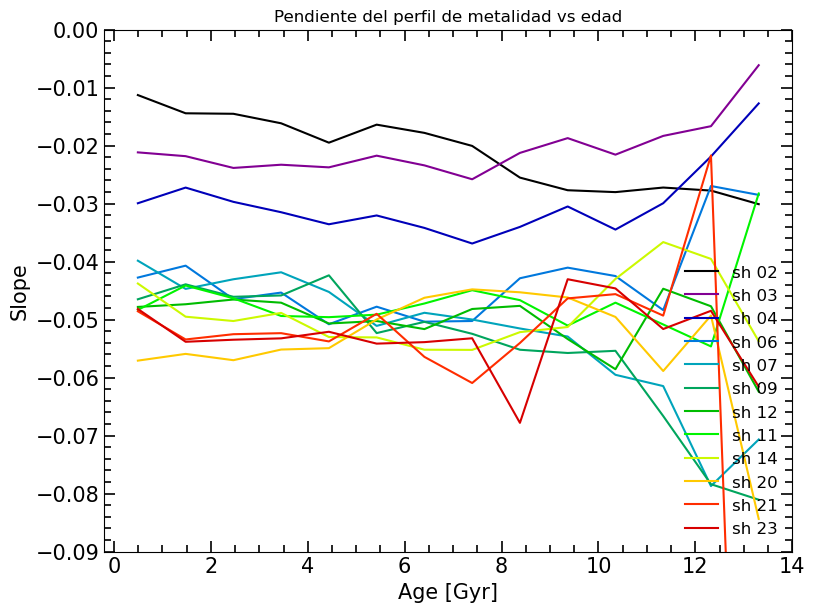

In [28]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_met_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    slope_tot = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope_tot,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.09,0.)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de metalidad vs edad')
ax.legend(fontsize=12,frameon=False)

## Metalicidad: pendiente en r50

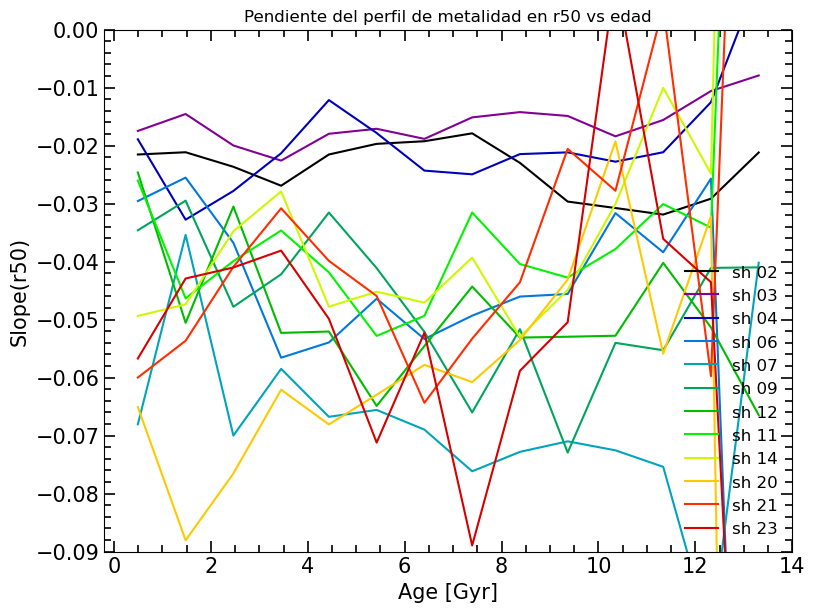

In [29]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_met_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    slope_r50 = data[:,2]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope_r50,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(-0.09,0.)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Slope(r50)',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de metalidad en r50 vs edad')
ax.legend(fontsize=12,frameon=False)

## Metalicidad: valor en r50

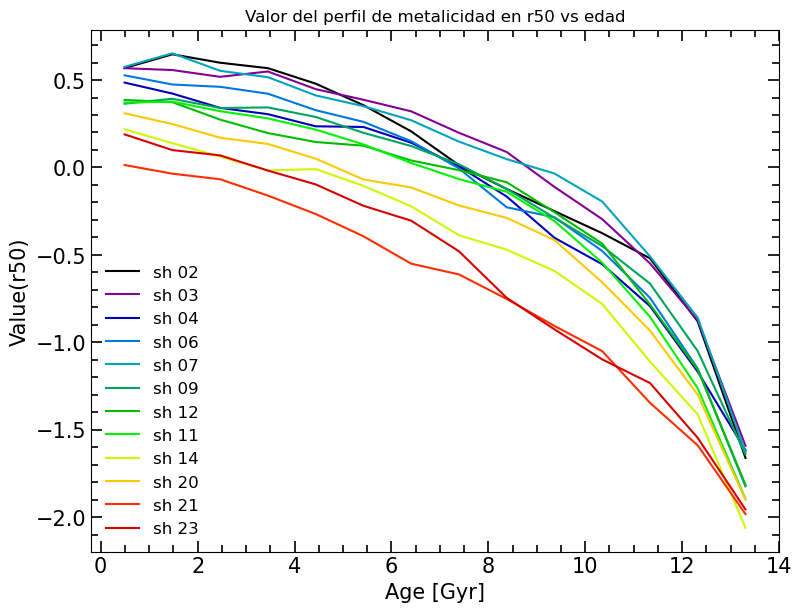

In [30]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_met_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    value_r50 = data[:,3]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,value_r50,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
# ax.set_ylim(-0.5,0.02)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Value(r50)',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Valor del perfil de metalicidad en r50 vs edad')
ax.legend(fontsize=12,frameon=False)

## z50


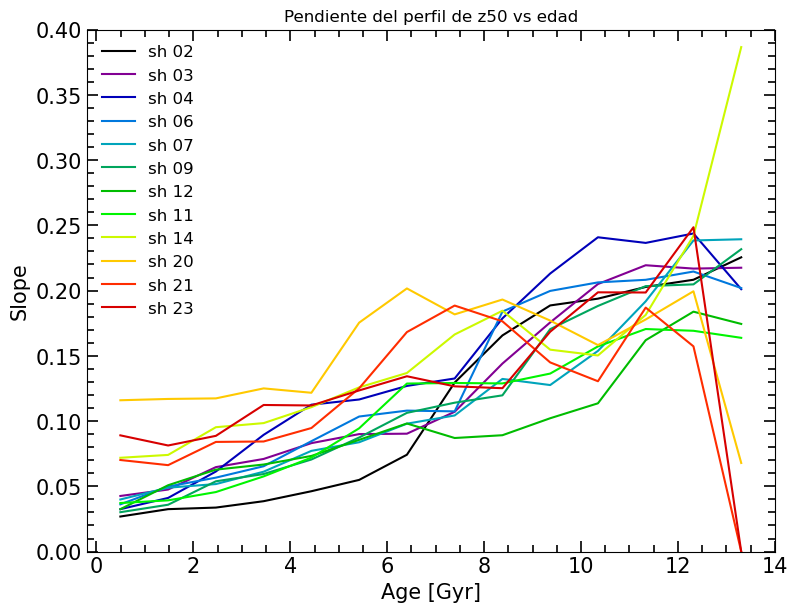

In [36]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_z50_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    slope_tot = data[:,1]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope_tot,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(0,0.4)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Slope',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de z50 vs edad')
ax.legend(fontsize=12,frameon=False)

## z50: pendiente en r50

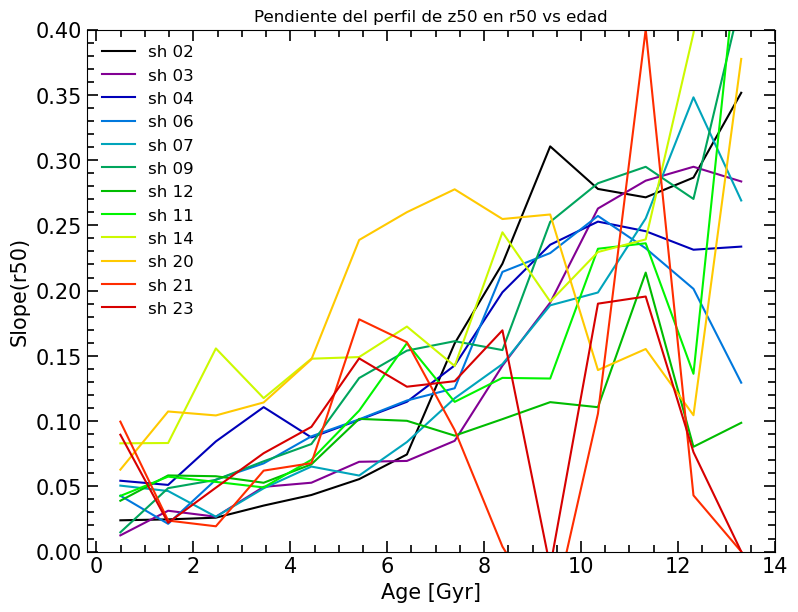

In [38]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_z50_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    slope_r50 = data[:,2]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,slope_r50,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
ax.set_ylim(0,0.4)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Slope(r50)',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Pendiente del perfil de z50 en r50 vs edad')
ax.legend(fontsize=12,frameon=False)

## z50: valor en r50

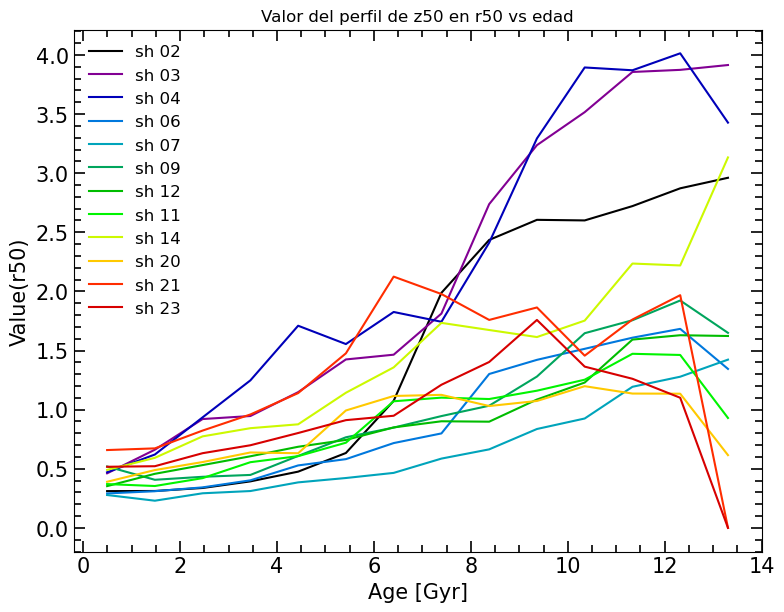

In [39]:
import matplotlib.pyplot as plt

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.98,top=0.97)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, 13))

for j in range(12):
    data = np.loadtxt('../_data/met_z50_slope_prof/slope_z50_perfil_sh_'+str('%d'%ID[j])+'_logbin.dat')

    age       = data[:,0]
    value_r50 = data[:,3]

    Id = ''
    for aux in list(str('%d'%ID[j]))[-2:]:
        Id += aux
        
    ax.plot(age,value_r50,'-', label='sh '+Id, color=colors[j])
    
ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right=True,top=True)
# ax.set_ylim(-0.5,0.02)
ax.set_xlim(-0.2,14)
ax.set_ylabel('Value(r50)',fontsize=15)
ax.set_xlabel('Age [Gyr]',fontsize=15)
ax.set_title('Valor del perfil de z50 en r50 vs edad')
ax.legend(fontsize=12,frameon=False)